### Remotely retrievable allometric relationships for gambel oak and new mexico locust in northern New Mexico
##### Dan J. Krofcheck, Marcy L. Litvak, Matthew D. Hurteau

Here we present the field generated relationships between height, volume, and dry biomass for two of the most pervasive post-fire shrub species in northern New Mexico.

Low cost photogrammetry projects from either manned or unmanned aircraft can leverage high image overlap to produce 3-dimensional point clouds of surface features, interpolate ground terrain, and gain some crude multi-spectral capabilities such as pseudo-NDVI with the use of makeshift filters. These photogrammetric techniques paired with machine learning and distributed computational capabilities allow the rapid scaling of field based allometry across plots to landscape scales.
    


#### Few project bookkeeping steps for managing the analysis in Python 3
Inclusions of GDAL here is for the next steps, and the application of these equations (and the PJ work which is largely completed) with UAS imagery. The virtual_env effort up front will be worth it when we start applying these equations to clouds of points associated with classified objects like shrubs or trees. Other than that, all of the fitting is handled via pandas dataframes and the statsmodels and scipy libraries.

In [1]:
# ------- Notebook Config ------- #
%matplotlib inline
import matplotlib.pyplot as plt

# ------- Libraries ------------- #
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Working directory
dataDir = 'C:/Research/JemezAllometries/'

#### A few calc and plotting functions to help out along the way

In [395]:
def pacalc(a,b):
    area = (a/2) * (b/2) * np.pi
    return area

def volcalc(a,b,height):
    volume = (4/3.) * (a/2) * (b/2) * height * np.pi
    return volume

def linfit(fitfunc, df):
    ols = smf.ols(fitfunc, df).fit()
    slope = (ols.params[1])
    intercept = (ols.params[0])
    return slope, intercept, smf.ols(fitfunc, df)

def plotLinFit(slope, intercept, Xmin, Xmax, ax=None, *args, **kwargs):
    y = []
    if ax == None:
        ax = plt.gca()
    for num in np.arange(Xmin, Xmax, 0.5):
         y.append(intercept + slope*num)
    ax.plot(np.arange(Xmin, Xmax, 0.5), y,*args, **kwargs)

### Read in the combined allometric data and calculate a volume field. 
We then subset the data by species to determine the impact on fit if we are unable to ID the shrub. Only useful if the implication is that we are planning on driving these allometries remotely - something I want to stress in the paper. Otherwise, we should have just measured stem diameters like the rest of the world.

In [74]:
master = pd.read_csv('jemez_allometry_master.csv')
master['area']   = pacalc(master['a'], master['b'])
master['volume'] = volcalc(master['a'], master['b'], master['height'])

rone = master[master.species == 'RONE']
quga = master[master.species == 'QUGA']
quga_289 = quga[quga.site == 'jfsp_289']
quga_vcp = quga[quga.site == 'vcp']

### Show the distributions of data
Here its important to point out that the data collected at the VCP site is composed of many small individuals. It may be worth discussing a 'growth morphology' flag to separate the stick or spheroid individuals. We can easily determine which we would be using remotely using some measure of how spherical something is.

Notice the distributions of volumes here are biased left, when we combine the data from both sites this is even more true, given the greater stem density and smaller stature of the quga growing at the VCP site.

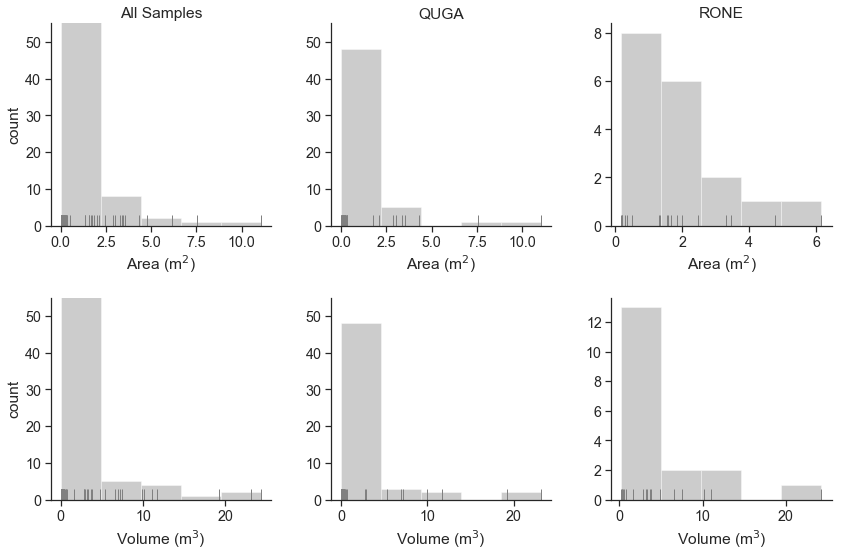

In [99]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (12,8))
axs = f.axes 
sns.distplot(master.area,ax = ax1, kde=False, rug=True, color = 'gray', bins=5)
sns.distplot(quga.area,ax = ax2, kde=False, rug=True, color = 'gray', bins=5)
sns.distplot(rone.area,ax = ax3, kde=False, rug=True, color = 'gray', bins=5)

sns.distplot(master.volume,ax = ax4, kde=False, rug=True, color = 'gray', bins=5)
sns.distplot(quga.volume,ax = ax5, kde=False, rug=True, color = 'gray', bins=5)
sns.distplot(rone.volume,ax = ax6, kde=False, rug=True, color = 'gray', bins=5)

ax1.set_title('All Samples')
ax2.set_title('QUGA')
ax3.set_title('RONE')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Area (m$^{2}$)')
for ax in [ax4, ax5, ax6]:
    ax.set_xlabel('Volume (m$^{3}$)')

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylim([0,55])
    ax.set_yticks([0,10,20,30,40,50])

ax1.set_ylabel('count')
ax4.set_ylabel('count')

sns.despine()
plt.tight_layout()
plt.savefig('area_volume_dist.tif')

### We expect the biomass of the shrub to be proportional to its volume
This isn't ground breaking science. Lets quickly plot some simple scatters and least squares fit lines to see how things look for each of the distributions shown above.

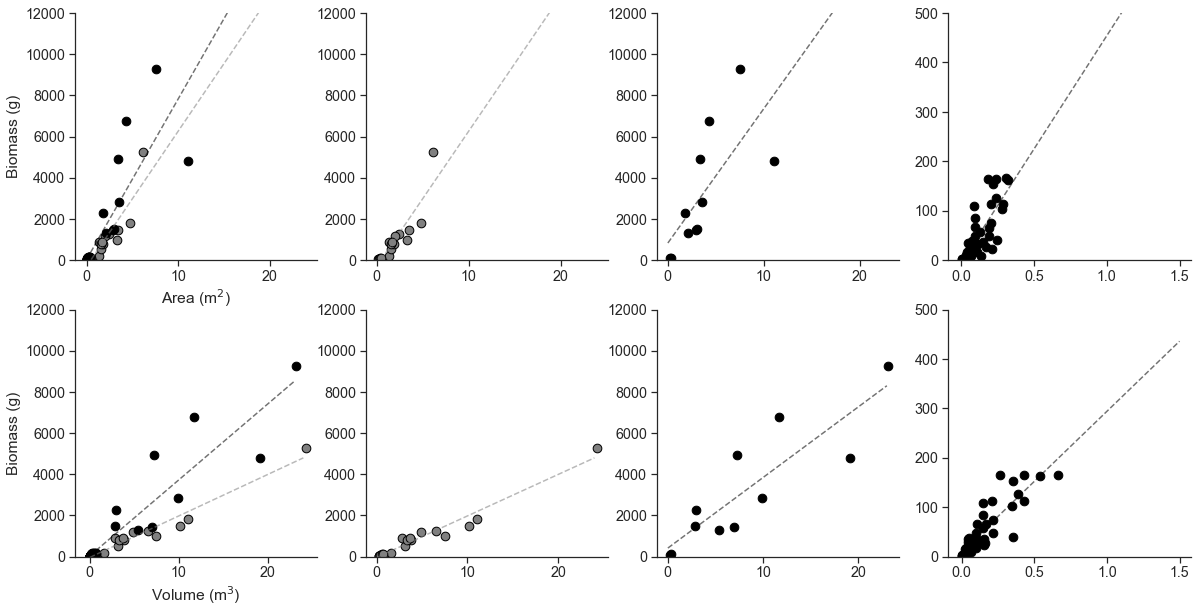

In [49]:
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize = (20,10))
axs = f.axes    

colors = ['gray','black']

idx = 0
for spec in ['RONE','QUGA']:
    toPlot = master[master.species == spec]
    ax1.scatter(toPlot.area, toPlot.biomass_t, 
                color = colors[idx], marker = 'o',  
                edgecolor='k', s = 75)
    idx += 1

idx = 0
for spec in ['RONE','QUGA']:
    toPlot = master[master.species == spec]
    ax5.scatter(toPlot.volume, toPlot.biomass_t, 
                color = colors[idx], marker = 'o',  
                edgecolor='k', s = 75)
    idx += 1

idx = 0   
for df in [rone, quga]:
    slope, intercept = linfit('biomass_t ~ area', df)
    plotLinFit(slope, intercept, 0, df.volume.max(), ax = ax1, ls = '--', color = colors[idx], alpha = 0.55)
    idx += 1
    
idx = 0   
for df in [rone, quga]:
    slope, intercept = linfit('biomass_t ~ volume', df)
    plotLinFit(slope, intercept, 0, df.volume.max(), ax = ax5, ls = '--', color = colors[idx], alpha = 0.55)
    idx += 1

ax2.scatter(rone.area, rone.biomass_t, 
        color = colors[0], marker = 'o',  
        edgecolor='k', s = 75)
slope, intercept = linfit('biomass_t ~ area', rone)
plotLinFit(slope, intercept, 0, rone.volume.max(), ax = ax2, ls = '--', color = colors[0], alpha = 0.55)

ax3.scatter(quga_289.area, quga_289.biomass_t, 
        color = colors[1], marker = 'o',  
        edgecolor='k', s = 75)
slope, intercept = linfit('biomass_t ~ area', quga_289)
plotLinFit(slope, intercept, 0, quga_289.volume.max(), ax = ax3, ls = '--', color = colors[1], alpha = 0.55)

ax4.scatter(quga_vcp.area, quga_vcp.biomass_t, 
        color = colors[1], marker = 'o',  
        edgecolor='k', s = 75)
slope, intercept = linfit('biomass_t ~ area', quga_vcp)
plotLinFit(slope, intercept, 0, 2, ax = ax4, ls = '--', color = colors[1], alpha = 0.55)

ax6.scatter(rone.volume, rone.biomass_t, 
        color = colors[0], marker = 'o',  
        edgecolor='k', s = 75)
slope, intercept = linfit('biomass_t ~ volume', rone)
plotLinFit(slope, intercept, 0, rone.volume.max(), ax = ax6, ls = '--', color = colors[0], alpha = 0.55)

ax7.scatter(quga_289.volume, quga_289.biomass_t, 
        color = colors[1], marker = 'o',  
        edgecolor='k', s = 75)
slope, intercept = linfit('biomass_t ~ volume', quga_289)
plotLinFit(slope, intercept, 0, quga_289.volume.max(), ax = ax7, ls = '--', color = colors[1], alpha = 0.55)

ax8.scatter(quga_vcp.volume, quga_vcp.biomass_t, 
        color = colors[1], marker = 'o',  
        edgecolor='k', s = 75)
slope, intercept = linfit('biomass_t ~ volume', quga_vcp)
plotLinFit(slope, intercept, 0, 2, ax = ax8, ls = '--', color = colors[1], alpha = 0.55)

    
ax.legend(['rone','quga'], fontsize = 15, loc = 0)
idx = 0

ax1.set_ylabel('Biomass (g)')
ax1.set_xlabel('Area (m$^{2}$)')

ax5.set_ylabel('Biomass (g)')
ax5.set_xlabel('Volume (m$^{3}$)')

for ax in axs:
    ax.set_ylim([0,12000])
for ax in [ax4, ax8]:
    ax.set_ylim([0,500])
    
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.3)

### Combine the RONE into a single column and clean up the formatting
This will be a tighter layout for the manuscript figs

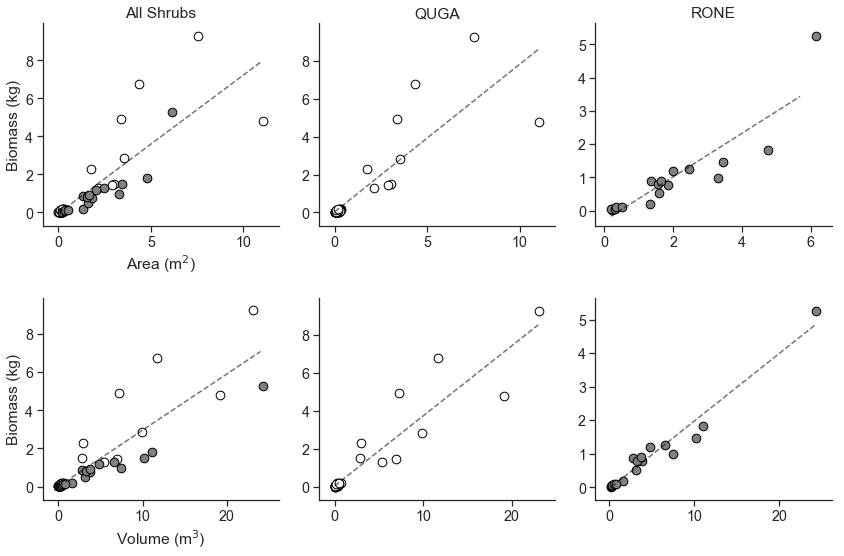

In [331]:
fitData = pd.DataFrame(dict(
                            SPECIES = master['species'],
                            SITE    = master['site'],
                            AREA  = master['area'],
                            VOLUME  = master['volume'],
                            BIOMASS = master['biomass_t']/1000))

quga = fitData[fitData.SPECIES == 'QUGA']
rone = fitData[fitData.SPECIES == 'RONE']

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (12,8))

slope, intercept, error = linfit('BIOMASS ~ AREA', fitData)
plotLinFit(slope, intercept, fitData.AREA.min(), fitData.AREA.max(), 
           ax = ax1,ls = '--', color = 'k', alpha = 0.55)

slope, intercept, error = linfit('BIOMASS ~ AREA', quga)
plotLinFit(slope, intercept, quga.AREA.min(), quga.AREA.max(), 
           ax = ax2,ls = '--', color = 'k', alpha = 0.55)

slope, intercept, error = linfit('BIOMASS ~ AREA', rone)
plotLinFit(slope, intercept, rone.AREA.min(), rone.AREA.max(), 
           ax = ax3,ls = '--', color = 'k', alpha = 0.55)

slope, intercept, error = linfit('BIOMASS ~ VOLUME', fitData)
plotLinFit(slope, intercept, fitData.VOLUME.min(), fitData.VOLUME.max(), 
           ax = ax4,ls = '--', color = 'k', alpha = 0.55)

slope, intercept, error = linfit('BIOMASS ~ VOLUME', quga)
plotLinFit(slope, intercept, quga.VOLUME.min(), quga.VOLUME.max(), 
           ax = ax5,ls = '--', color = 'k', alpha = 0.55)

slope, intercept, error = linfit('BIOMASS ~ VOLUME', rone)
plotLinFit(slope, intercept, rone.VOLUME.min(), rone.VOLUME.max(), 
           ax = ax6,ls = '--', color = 'k', alpha = 0.55)

ax1.scatter(quga.AREA, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax1.scatter(rone.AREA, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax4.scatter(quga.VOLUME, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax4.scatter(rone.VOLUME, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax2.scatter(quga.AREA, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax3.scatter(rone.AREA, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax5.scatter(quga.VOLUME, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax6.scatter(rone.VOLUME, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)


ax1.set_ylabel('Biomass (kg)')
ax4.set_ylabel('Biomass (kg)')
ax1.set_xlabel('Area (m$^{2}$)')
ax4.set_xlabel('Volume (m$^{3}$)')

ax1.set_title('All Shrubs')
ax2.set_title('QUGA')
ax3.set_title('RONE')

sns.despine()
sns.set_style('ticks')
plt.tight_layout()
plt.savefig('shrub_biomass.tif')

### Several prominent papers in the field of allometry
both new and old, have had recent discussions on bivariate distributions, and the wide misconceptions regarding power law applications to biomass prediction, log transformations vs weibull modeling etc. We have a clear path forward, choosing to fit separate models to young (small) and old (large) individuals, and by including species as a covariate. This way we can get along just fine taking the natural log of both biomass and volume to fit the model, then back-transforming the model with the inclusion of the correction factor and associated regression error (e.g., Baskerville 1972).

Below is the log transformed model performance for all species and sizes

In [333]:
fitData = pd.DataFrame(dict(
                            SPECIES = master['species'],
                            SITE    = master['site'],
                            AREA  = np.log(master['area']),
                            VOLUME  = np.log(master['volume']),
                            BIOMASS = np.log(master['biomass_t']/1000)))

ols = smf.ols('BIOMASS ~ AREA', fitData).fit()
slope = (ols.params['AREA'])
intercept = (ols.params['Intercept'])

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                BIOMASS   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     590.7
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           3.85e-36
Time:                        13:58:51   Log-Likelihood:                -73.909
No. Observations:                  73   AIC:                             151.8
Df Residuals:                      71   BIC:                             156.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8231      0.098     -8.402      0.0

In [27]:
ols = smf.ols('BIOMASS ~ VOLUME', fitData).fit()
slope = (ols.params['VOLUME'])
intercept = (ols.params['Intercept'])

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                BIOMASS   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     845.7
Date:                Fri, 29 Mar 2019   Prob (F-statistic):           3.57e-41
Time:                        12:11:30   Log-Likelihood:                -62.010
No. Observations:                  73   AIC:                             128.0
Df Residuals:                      71   BIC:                             132.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2838      0.075    -17.204      0.0

#### Now we can split that up into both QUGA and RONE components

In [34]:
quga = fitData[fitData.SPECIES == 'QUGA']
rone = fitData[fitData.SPECIES == 'RONE']

ols_quga = smf.ols('BIOMASS ~ AREA', quga).fit()
slope_quga = (ols_quga.params['AREA'])
intercept_quga = (ols_quga.params['Intercept'])

ols_rone = smf.ols('BIOMASS ~ AREA', rone).fit()
slope_rone = (ols_rone.params['AREA'])
intercept_rone = (ols_rone.params['Intercept'])

print(ols_quga.summary())
print(ols_rone.summary())

                            OLS Regression Results                            
Dep. Variable:                BIOMASS   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     385.7
Date:                Fri, 29 Mar 2019   Prob (F-statistic):           5.51e-26
Time:                        12:13:25   Log-Likelihood:                -58.252
No. Observations:                  55   AIC:                             120.5
Df Residuals:                      53   BIC:                             124.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6976      0.138     -5.050      0.0

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


In [334]:
quga = fitData[fitData.SPECIES == 'QUGA']
rone = fitData[fitData.SPECIES == 'RONE']

ols_quga = smf.ols('BIOMASS ~ VOLUME', quga).fit()
slope_quga = (ols_quga.params['VOLUME'])
intercept_quga = (ols_quga.params['Intercept'])

ols_rone = smf.ols('BIOMASS ~ VOLUME', rone).fit()
slope_rone = (ols_rone.params['VOLUME'])
intercept_rone = (ols_rone.params['Intercept'])

#### QUGA (two site model)

In [32]:
print(ols_quga.summary())

                            OLS Regression Results                            
Dep. Variable:                BIOMASS   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     592.0
Date:                Fri, 29 Mar 2019   Prob (F-statistic):           1.97e-30
Time:                        12:13:11   Log-Likelihood:                -47.649
No. Observations:                  55   AIC:                             99.30
Df Residuals:                      53   BIC:                             103.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1246      0.101    -11.145      0.0

#### RONE

In [33]:
print(ols_rone.summary())

                            OLS Regression Results                            
Dep. Variable:                BIOMASS   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     594.1
Date:                Fri, 29 Mar 2019   Prob (F-statistic):           4.45e-14
Time:                        12:13:14   Log-Likelihood:              -0.098542
No. Observations:                  18   AIC:                             4.197
Df Residuals:                      16   BIC:                             5.978
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7581      0.069    -25.344      0.0

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


### Moving toward a more robust prediction
We should do some model fitting work, namely some cross validation. LOOCV is the best approach to use here given the small sample size and lack of computation complexity. Let's run it on our model and see how it performs. I expect given the strong bivariate distribution of our data, LOOCV will prove to be fairly robust. A k-folds approach would actually poke more holes in the effort here, but thats beside the point given that we will probably report the total and 'small' allometries as separate entities in an effort to be as robust as possible.

Not implemented here, the bootstrapping should take care of this - need to update the kfolds workflow for the PJ stuff

### If we look at the resulting transformed data
The accuracy of the resulting linear model is obvious. We need to think about taking the MSE from the LOOCV and adding it into the model uncertainty term, but the current framework should make that fairly straight forward if we decide to do it. We can produce these curves for either all shrubs, or the separated species.

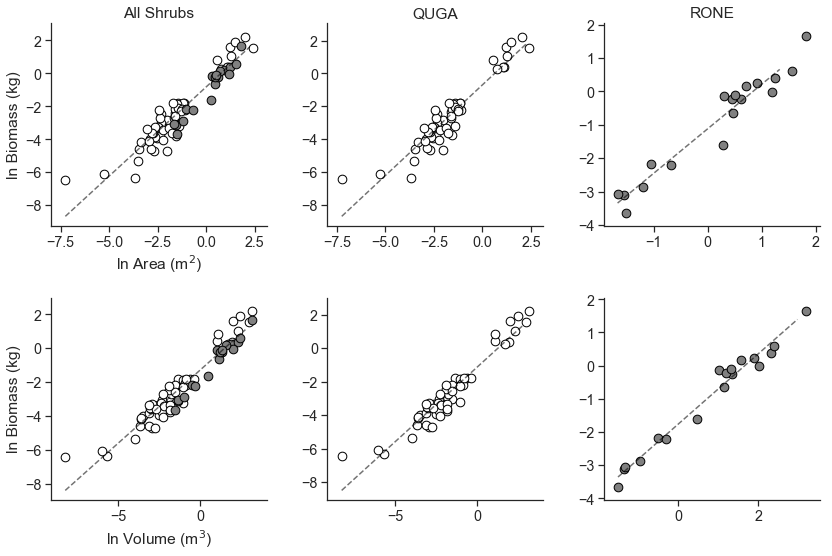

In [335]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (12,8))

slope, intercept, error = linfit('BIOMASS ~ AREA', fitData)
plotLinFit(slope, intercept, fitData.AREA.min(), fitData.AREA.max(), 
           ax = ax1,ls = '--', color = 'k', alpha = 0.55)

slope, intercept, error = linfit('BIOMASS ~ AREA', quga)
plotLinFit(slope, intercept, quga.AREA.min(), quga.AREA.max(), 
           ax = ax2,ls = '--', color = 'k', alpha = 0.55)

slope, intercept, error = linfit('BIOMASS ~ AREA', rone)
plotLinFit(slope, intercept, rone.AREA.min(), rone.AREA.max(), 
           ax = ax3,ls = '--', color = 'k', alpha = 0.55)

slope, intercept, error = linfit('BIOMASS ~ VOLUME', fitData)
plotLinFit(slope, intercept, fitData.VOLUME.min(), fitData.VOLUME.max(), 
           ax = ax4,ls = '--', color = 'k', alpha = 0.55)

slope, intercept, error = linfit('BIOMASS ~ VOLUME', quga)
plotLinFit(slope, intercept, quga.VOLUME.min(), quga.VOLUME.max(), 
           ax = ax5,ls = '--', color = 'k', alpha = 0.55)

slope, intercept, error = linfit('BIOMASS ~ VOLUME', rone)
plotLinFit(slope, intercept, rone.VOLUME.min(), rone.VOLUME.max(), 
           ax = ax6,ls = '--', color = 'k', alpha = 0.55)

ax1.scatter(quga.AREA, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax1.scatter(rone.AREA, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax4.scatter(quga.VOLUME, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax4.scatter(rone.VOLUME, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax2.scatter(quga.AREA, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax3.scatter(rone.AREA, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax5.scatter(quga.VOLUME, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax6.scatter(rone.VOLUME, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)


ax1.set_ylabel('ln Biomass (kg)')
ax4.set_ylabel('ln Biomass (kg)')
ax1.set_xlabel('ln Area (m$^{2}$)')
ax4.set_xlabel('ln Volume (m$^{3}$)')

ax1.set_title('All Shrubs')
ax2.set_title('QUGA')
ax3.set_title('RONE')

sns.despine()
sns.set_style('ticks')
plt.tight_layout()
plt.savefig('shrub_biomass_ln.tif')

### Now we want to recreate these regressions and leverage the uncertainty
in our measurements to create an ensemble of curve fits, from which we can produce a mean and variance of the fit parameters. This will allow us to use MC approaches to estimating uncertainty in our allometry when we apply the regressions to real world scenarios. We'll start by describing the uncertainty in area, volume, and biomass.

Both area and volume measurements were made at +/- 1cm precision in our field study. 

In [138]:
def pacalc(a,b):
    area = (a/2) * (b/2) * np.pi
    area_e = np.sqrt((0.01 / (a/2))**2 + (0.01 / (b/2))**2) * np.pi * area
    return area, area_e

def volcalc(a,b,height):
    volume = (4/3.) * (a/2) * (b/2) * height * np.pi
    volume_e = np.sqrt((0.01 / (a/2))**2 + (0.01 / (b/2))**2 + (0.01 / height)**2) * np.pi * volume * (4/3.)

    return volume, volume_e

master = pd.read_csv('jemez_allometry_master.csv')
master['area'], master['area_e']   = pacalc(master['a'], master['b'])
master['volume'], master['volume_e'] = volcalc(master['a'], master['b'], master['height'])

The uncertainty in our biomass estimates comes from the balance we used (+/- 0.01g) which has to be a function of the number of bags weighed for each individual shrub. 

In [139]:
master['biomass_e'] = np.sqrt(0.01**2 * master['bagnum_t'])

### Now that we have the ucnertainty assocaited with area, volume, and biomass
we can bootstrap our linear regression by drawing our X and Y values from distributions informed by their respective uncertainties. This will let us report a mean and variance for the parameter fits and the associated RMSE. We'll use a random draw from a normal distribution with mean 0 and variance 0.5 to select multipliers for our uncertainty values for area, volume, and biomass respectively. 

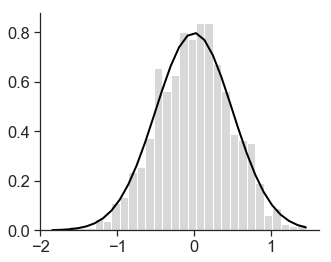

In [698]:
f, ax1 = plt.subplots(1,1, figsize = (5,4))

mu = 0
sigma = 0.5

dist = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(dist, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
    np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
    linewidth=2, color='k')

sns.despine()

fitData = pd.DataFrame(dict(
                            SPECIES = master['species'],
                            SITE    = master['site'],
                            AREA  = master['area'],
                            VOLUME  = master['volume'],
                            BIOMASS = master['biomass_t']/1000,
                            AREA_e  = master['area_e'],
                            VOLUME_e   = master['volume_e'],
                            BIOMASS_e  = master['biomass_e']/1000))

### What proportion of these shrubs are foliar vs wood?
We can't figure that out without using more 'representative' branch samples, or parsing out the foliage from whole shrub harvests. Maybe we can include those data as an addendum of some sort following next field season. It would be a nice way to use volume to determine foliar biomass, and subsequently LAI. 

We do however have the specific leaf area from leaf scans, and can report those as some distributions by species.

In [637]:
slopes_ac = []
intercepts_ac = []
adj_r2_ac = []
rmse_ac = []

slopes_vc = []
intercepts_vc = []
adj_r2_vc = []
rmse_vc = []

slopes_aq = []
intercepts_aq = []
adj_r2_aq = []
rmse_aq = []

slopes_vq = []
intercepts_vq = []
adj_r2_vq = []
rmse_vq = []

slopes_ar = []
intercepts_ar = []
adj_r2_ar = []
rmse_ar = []

slopes_vr = []
intercepts_vr = []
adj_r2_vr = []
rmse_vr = []

for MCi in np.arange(1000):
    randomMult = [np.random.normal(mu, sigma, 1)[0] for k in fitData.index]
    fitData['realizedArea'] = (randomMult * fitData.AREA_e) + fitData.AREA

    randomMult = [np.random.normal(mu, sigma, 1)[0] for k in fitData.index]
    fitData['realizedVolume'] = (randomMult * fitData.VOLUME_e) + fitData.VOLUME

    randomMult = [np.random.normal(mu, sigma, 1)[0] for k in fitData.index]
    fitData['realizedBiomass'] = (randomMult * fitData.BIOMASS_e) + fitData.BIOMASS

    fitMC = pd.DataFrame(dict(
                                SPECIES = fitData['SPECIES'],
                                SITE    = fitData['SITE'],
                                AREA  = np.log(fitData['realizedArea']),
                                VOLUME  = np.log(fitData['realizedVolume']),
                                BIOMASS = np.log(fitData['realizedBiomass'])))

    quga = fitMC[fitData.SPECIES == 'QUGA']
    rone = fitMC[fitData.SPECIES == 'RONE']

    slope, intercept, model_ac = linfit('BIOMASS ~ AREA', fitMC)
    slopes_ac.append(slope)
    intercepts_ac.append(intercept)
    adj_r2_ac.append(model_ac.fit().rsquared_adj)
    diffs = np.square(model_ac.fit().predict(fitMC.AREA) - fitMC.BIOMASS)
    RMSE = np.sqrt(np.mean(diffs))
    rmse_ac.append(RMSE)
    
    slope, intercept, model_aq = linfit('BIOMASS ~ AREA', quga)
    slopes_aq.append(slope)
    intercepts_aq.append(intercept)
    adj_r2_aq.append(model_aq.fit().rsquared_adj)
    diffs = np.square(model_aq.fit().predict(quga.AREA) - quga.BIOMASS)
    RMSE = np.sqrt(np.mean(diffs))
    rmse_aq.append(RMSE)

    slope, intercept, model_ar = linfit('BIOMASS ~ AREA', rone)
    slopes_ar.append(slope)
    intercepts_ar.append(intercept)
    adj_r2_ar.append(model_ar.fit().rsquared_adj)
    diffs = np.square(model_ar.fit().predict(rone.AREA) - rone.BIOMASS)
    RMSE = np.sqrt(np.mean(diffs))
    rmse_ar.append(RMSE)

    slope, intercept, model_vc = linfit('BIOMASS ~ VOLUME', fitMC)
    slopes_vc.append(slope)
    intercepts_vc.append(intercept)
    adj_r2_vc.append(model_vc.fit().rsquared_adj)
    diffs = np.square(model_vc.fit().predict(fitMC.VOLUME) - fitMC.BIOMASS)
    RMSE = np.sqrt(np.mean(diffs))
    rmse_vc.append(RMSE)

    slope, intercept, model_vq = linfit('BIOMASS ~ VOLUME', quga)
    slopes_vq.append(slope)
    intercepts_vq.append(intercept)
    adj_r2_vq.append(model_vq.fit().rsquared_adj)
    diffs = np.square(model_vq.fit().predict(quga.VOLUME) - quga.BIOMASS)
    RMSE = np.sqrt(np.mean(diffs))
    rmse_vq.append(RMSE)

    slope, intercept, model_vr = linfit('BIOMASS ~ VOLUME', rone)
    slopes_vr.append(slope)
    intercepts_vr.append(intercept)
    adj_r2_vr.append(model_vr.fit().rsquared_adj)
    diffs = np.square(model_vr.fit().predict(rone.VOLUME) - rone.BIOMASS)
    RMSE = np.sqrt(np.mean(diffs))
    rmse_vr.append(RMSE)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log


### Now that we have the arrays of fit statistics 
generated from the random perturbation in input data, we can present a mean and variance of curve fit parameters to associate with each model. Here we're only looking at the log normalized inputs, given their superior performance  and ability to handle the wide range in shrub sizes without weighting the cost function too heavily for the small shrubs.

In [638]:
fit_ac = pd.DataFrame(dict(group = 'AC', slopes = slopes_ac, intercepts = intercepts_ac, adjr2 = adj_r2_ac, rmse = rmse_ac))
fit_aq = pd.DataFrame(dict(group = 'AQ', slopes = slopes_aq, intercepts = intercepts_aq, adjr2 = adj_r2_aq, rmse = rmse_aq))
fit_ar = pd.DataFrame(dict(group = 'AR', slopes = slopes_ar, intercepts = intercepts_ar, adjr2 = adj_r2_ar, rmse = rmse_ar))
fit_vc = pd.DataFrame(dict(group = 'VC', slopes = slopes_vc, intercepts = intercepts_vc, adjr2 = adj_r2_vc, rmse = rmse_vc))
fit_vq = pd.DataFrame(dict(group = 'VQ', slopes = slopes_vq, intercepts = intercepts_vq, adjr2 = adj_r2_vq, rmse = rmse_vq))
fit_vr = pd.DataFrame(dict(group = 'VR', slopes = slopes_vr, intercepts = intercepts_vr, adjr2 = adj_r2_vr, rmse = rmse_vr))
allMC_Fits = pd.concat([fit_ac,fit_aq,fit_ar,fit_vc,fit_vq,fit_vr])

In [639]:
from statsmodels.stats.outliers_influence import summary_table
st, data, ss2 = summary_table(model_ac.fit(), alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T



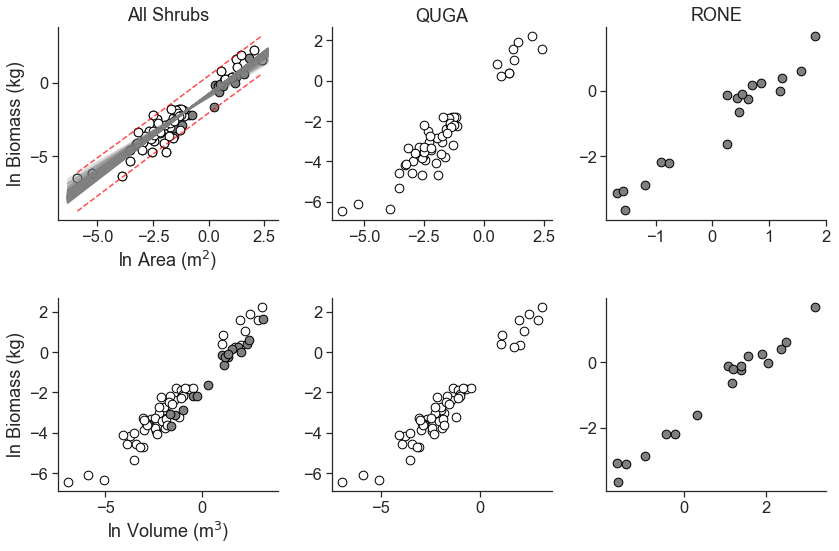

In [640]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (12,8))

ax1.scatter(quga.AREA, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax1.scatter(rone.AREA, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax4.scatter(quga.VOLUME, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax4.scatter(rone.VOLUME, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax2.scatter(quga.AREA, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax3.scatter(rone.AREA, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

ax5.scatter(quga.VOLUME, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

ax6.scatter(rone.VOLUME, rone.BIOMASS, 
        color = 'gray', marker = 'o',  
        edgecolor='k', s = 75)

xmin, xmax = ax1.get_xlim()
xvals = np.arange(xmin, xmax)

for idx in np.arange(len(allMC_Fits[allMC_Fits.group == 'AC'])):
    intercept = allMC_Fits[allMC_Fits.group == 'AC'].intercepts[idx]
    slope = allMC_Fits[allMC_Fits.group == 'AC'].slopes[idx]

    yvals = slope * xvals + intercept
    ax1.plot(xvals, yvals, '-', color = 'gray', alpha = 0.1)
    
ax1.scatter(quga.AREA, quga.BIOMASS, 
        color = 'white', marker = 'o',  
        edgecolor='k', s = 75)

toPlot = pd.DataFrame(dict(xvals = fitMC.AREA, yvalslow = predict_ci_low, yvalsupp = predict_ci_upp))
toPlot = toPlot.sort_values('xvals')
ax1.plot(toPlot.xvals, toPlot.yvalslow, '--r', alpha = 0.7)
ax1.plot(toPlot.xvals, toPlot.yvalsupp, '--r', alpha = 0.7)

ax1.set_ylabel('ln Biomass (kg)')
ax4.set_ylabel('ln Biomass (kg)')
ax1.set_xlabel('ln Area (m$^{2}$)')
ax4.set_xlabel('ln Volume (m$^{3}$)')

ax1.set_title('All Shrubs')
ax2.set_title('QUGA')
ax3.set_title('RONE')

sns.despine()
sns.set_style('ticks')

plt.tight_layout()
sns.set_context('notebook',font_scale=1.5)




plt.tight_layout()

### Summarize the statistics for the regressions

#### Slope

In [703]:
allMC_Fits.groupby('group').slopes.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
AC,1000.0,1.090003,0.047930,0.863693,1.066491,1.096647,1.122350,1.179713
AQ,1000.0,1.117351,0.064982,0.822111,1.084723,1.125733,1.160720,1.237200
AR,1000.0,1.331138,0.021931,1.252874,1.316529,1.331785,1.346163,1.396520
VC,1000.0,0.872281,0.029947,0.725476,0.855584,0.875984,0.892761,0.938596
VQ,1000.0,0.908288,0.042130,0.706753,0.884736,0.913110,0.936956,0.999670
VR,1000.0,1.051975,0.017011,0.994556,1.040828,1.052074,1.063215,1.100685


#### Intercept

In [704]:
allMC_Fits.groupby('group').intercepts.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
AC,1000.0,-0.815702,0.041882,-1.033918,-0.832871,-0.807933,-0.787145,-0.748795
AQ,1000.0,-0.679802,0.086709,-1.098856,-0.720939,-0.667214,-0.622445,-0.529886
AR,1000.0,-1.116705,0.019463,-1.179998,-1.130438,-1.116935,-1.103105,-1.051506
VC,1000.0,-1.276930,0.017457,-1.382179,-1.285459,-1.274570,-1.265495,-1.234530
VQ,1000.0,-1.106038,0.046546,-1.380819,-1.127967,-1.099212,-1.073960,-1.009880
VR,1000.0,-1.752549,0.029511,-1.853671,-1.772684,-1.752111,-1.733423,-1.664122


#### RMSE

In [705]:
allMC_Fits.groupby('group').rmse.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
AC,1000.0,0.667403,0.055249,0.560202,0.631766,0.654592,0.688611,0.970999
AQ,1000.0,0.696086,0.070264,0.557989,0.649380,0.681572,0.725822,1.055096
AR,1000.0,0.378031,0.015125,0.333084,0.367645,0.377324,0.387599,0.434423
VC,1000.0,0.566619,0.043582,0.487895,0.537707,0.558517,0.584760,0.849826
VQ,1000.0,0.571050,0.060358,0.459216,0.529887,0.560816,0.598813,0.933519
VR,1000.0,0.253189,0.015015,0.209890,0.242733,0.252896,0.262537,0.303510


#### Adjusted R2

In [707]:
allMC_Fits.groupby('group').adjr2.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
AC,1000.0,0.888561,0.018989,0.757269,0.883214,0.893747,0.900254,0.919212
AQ,1000.0,0.874644,0.026149,0.703918,0.866127,0.881642,0.891057,0.917198
AR,1000.0,0.932623,0.005407,0.911161,0.929283,0.932983,0.936374,0.947778
VC,1000.0,0.919303,0.012511,0.822818,0.915071,0.921958,0.927238,0.941587
VQ,1000.0,0.915089,0.018304,0.779686,0.908324,0.918998,0.927167,0.943173
VR,1000.0,0.969719,0.003607,0.956638,0.967555,0.969893,0.972266,0.979263


### What proportion of these shrubs are foliar vs wood?
We can't figure that out without using more 'representative' branch samples, or parsing out the foliage from whole shrub harvests. Maybe we can include those data as an addendum of some sort following next field season. It would be a nice way to use volume to determine foliar biomass, and subsequently LAI. 

We do however have the specific leaf area from leaf scans, and can report those as some distributions by species.

In [100]:
jemez_LA = pd.read_csv('jemez_allometry_LA.csv')
jemez_LA
jemez_LA['fracFoliar_LS'] = jemez_LA.leafb_g / (jemez_LA.woodb_g + jemez_LA.leafb_g)
jemez_LA['SLA'] = jemez_LA.leafb_g / jemez_LA.ls_total_area_cm2 

print(jemez_LA.groupby('species').mean().SLA)
print(jemez_LA.groupby('species').std().SLA)

species
QUGA    0.010439
RONE    0.009157
Name: SLA, dtype: float64
species
QUGA    0.000977
RONE    0.000850
Name: SLA, dtype: float64


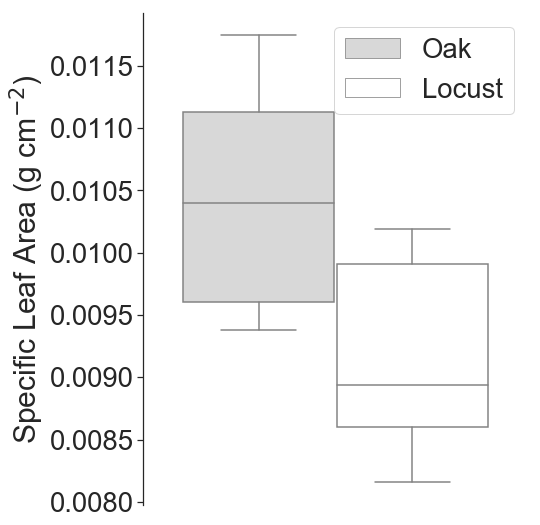

In [523]:
flatui = ["#d8d8d8", "white"]
sns.set_palette(flatui)
f, ax1, = plt.subplots(1,1, figsize = (8,8))
g = sns.boxplot(y = 'SLA', x = 'site', hue = 'species',data = jemez_LA, 
            palette=flatui, color = 'black', ax = ax1)

ax1.set_ylabel('Specific Leaf Area (g cm$^{-2}$)')
ax1.set_xlabel('')
ax1.set_xticklabels([])
ax1.set_xticks([])


ax1.get_legend().set_title('')
# replace labels
new_labels = ['Oak', 'Locust']

for t, l in zip(ax1.get_legend().texts, new_labels): 
    t.set_text(l)

sns.despine(bottom=True)
plt.tight_layout()
sns.set_context('notebook',font_scale=2.5)
plt.savefig('SLA_Boxplot.tif')

In [526]:
import scipy.stats

scipy.stats.ttest_ind(jemez_LA[jemez_LA.species == 'QUGA'].SLA, jemez_LA[jemez_LA.species == 'RONE'].SLA)

Ttest_indResult(statistic=2.4246116726791747, pvalue=0.03577836682281283)

### Robust model prediction for error propagation
I think we should bootstrap the regressions using the standard error or variance of as many sources of uncertainty as we can manage, including measurement uncertainty from tapes and balances. We can use a simple MC approach to building the model, the net effect is just an increase in the uncertainty of the regressions. We can afford that given the high R2, but when we translate the uncertainty in terms of biomass the numbers are still tiny, but relatively large in some cases.

We also need to address the consequences of how uncertainty is bracketed for large or small shrubs, and by species. I am thinking about a section in the pub in the results or discussion related to the contextualization of the allometry for remote retrieval from high resolution remote sensing (satellite or UAS). In that effort I want to calculate the ellopsoid cross sectional area and run the same models soley with 2D inputs.

### Now we can apply the regressions to an example spatial data set
In this case, a chunk of sUAS acquired structure from motion data. I worked up this imagery using a combination of open source and proprietery tools including RTKLib, Python, Agisoft Photoscan, QGIS, and SAGA. The workflow involved collecting images concurrent with GNSS geodata on a sUAS in the field and processing them using the structure from motion multi-view stereo workflow (SfM MVS), producing an orthophoto and a digital surface model. I then used a combination of geospatial algorithms to approximate the digital terrain model and subsequent height model. I used a combination of region growing and inverse-watershed algorithms to delineate individual objects in the scene and exported those objects as features in an ESRI shapefile. Finally I used that shapefile to compute zonal statistics on the height model, producing descriptive stats for each object in the scene.

So we can read in the attribute file for the segmented objects and use the area and volume of each object to compute the biomass following the equations above. Further, we can propagate the error through as well -- ultimately, we will make two maps - the mean biomass and mean uncertainty per ojbect when we run the regressions for 1000 iterations.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


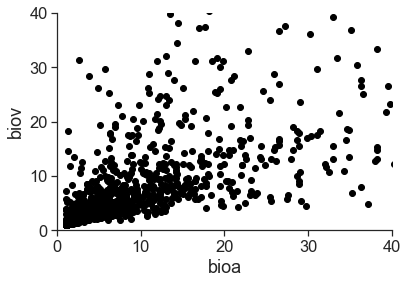

In [711]:
# The raw segment statistics - here we are assuming that there is no uncertainty in the
# remote estimations of area or volume, mostly because we haven't measured them.

segstats = pd.read_csv('X:/JemezAllometryDemo/segmentStatistics.csv')

segstats['biomassArea'] = np.exp(allMC_Fits[allMC_Fits.group == 'AC'].slopes.mean() * np.log(segstats['Area2']) +\
    allMC_Fits[allMC_Fits.group == 'AC'].intercepts.mean())

segstats['biomassVolume'] = np.exp(allMC_Fits[allMC_Fits.group == 'VC'].slopes.mean() * \
    np.log(segstats['Area2']*segstats._max) +\
    allMC_Fits[allMC_Fits.group == 'VC'].intercepts.mean())

plt.plot(np.exp(segstats.biomassArea), np.exp(segstats.biomassVolume), 'ok')
plt.xlabel('bioa')
plt.ylabel('biov')
plt.xlim([0,40])
plt.ylim([0,40])
sns.despine()

### MC application of the allometry for area and volume will inhereit the measurement uncertainty
since we will draw from the distribution of means and variances to c